In [1]:
#!pip install tensorflow
#!pip install yfinance

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [3]:
stock_symbol = 'BTC-USD' ##change to any ticker of your choice

In [4]:
data = yf.download(tickers = stock_symbol,period ='5y',interval ='1d')

[*********************100%***********************]  1 of 1 completed


In [5]:
type(data)

pandas.core.frame.DataFrame

In [6]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-24,14608.200195,14626.000000,12747.700195,13925.799805,13925.799805,11572299776
2017-12-25,13995.900391,14593.000000,13448.900391,14026.599609,14026.599609,10664699904
2017-12-26,14036.599609,16461.199219,14028.900391,16099.799805,16099.799805,13454300160
2017-12-27,16163.500000,16930.900391,15114.299805,15838.500000,15838.500000,12487600128
2017-12-28,15864.099609,15888.400391,13937.299805,14606.500000,14606.500000,12336499712


In [7]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-20,16441.787109,17012.984375,16427.867188,16906.304688,16906.304688,22722096615
2022-12-21,16904.527344,16916.800781,16755.912109,16817.535156,16817.535156,14882945045
2022-12-22,16818.380859,16866.673828,16592.408203,16830.341797,16830.341797,16441573050
2022-12-23,16829.644531,16905.218750,16794.458984,16796.953125,16796.953125,15329265213
2022-12-24,16794.287109,16855.216797,16794.287109,16843.947266,16843.947266,11142657024


In [8]:
adj_close = data[['Adj Close']] ## change to either open,high,low,close & adj close

<AxesSubplot:xlabel='Date'>

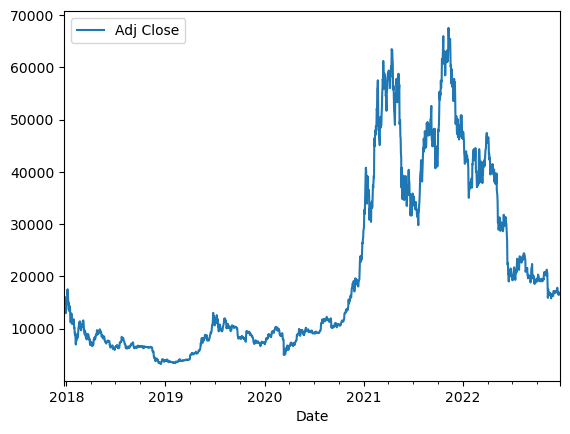

In [9]:
adj_close.plot()

In [10]:
ds = adj_close.values

In [11]:
ds

array([[13925.79980469],
       [14026.59960938],
       [16099.79980469],
       ...,
       [16830.34179688],
       [16796.953125  ],
       [16843.94726562]])

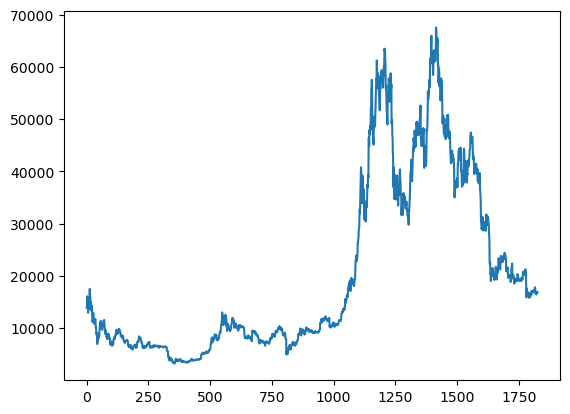

In [12]:
plt.plot(ds);

In [13]:
#standardize data
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [14]:
len(ds_scaled),len(ds)

(1827, 1827)

In [15]:
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled)-train_size

In [16]:
train_size,test_size

(1278, 549)

In [17]:
ds_train,ds_test = ds_scaled[0:train_size,:],ds_scaled[train_size:len(ds_scaled),:1]

In [18]:
len(ds_train),len(ds_test)

(1278, 549)

In [19]:
#creating dataset in time series for LSTM
def create_ds(dataset,step):
    Xtrain,Ytrain = [],[]
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step),0]
        Xtrain.append(a)
        Ytrain.append(dataset[i+step,0])
    return np.array(Xtrain),np.array(Ytrain)

In [20]:
#taking 100 days price as one record for training
time_stamp = 100
x_train,y_train = create_ds(ds_train,time_stamp)
x_test,y_test = create_ds(ds_test,time_stamp)

In [21]:
x_train.shape,y_train.shape

((1177, 100), (1177,))

In [22]:
x_test.shape,y_test.shape

((448, 100), (448,))

In [23]:
#reshaping data to fit into LSTM model
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test =x_test.reshape(x_test.shape[0],x_test.shape[1],1)


In [24]:
#creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [25]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer = 'adam')
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
19/19 [==============================] - 14s 229ms/step - loss: 0.0165 - val_loss: 0.0187
Epoch 2/100
19/19 [==============================] - 3s 134ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 3/100
19/19 [==============================] - 2s 127ms/step - loss: 0.0019 - val_loss: 0.0037
Epoch 4/100
19/19 [==============================] - 2s 127ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 5/100
19/19 [==============================] - 2s 126ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 6/100
19/19 [==============================] - 2s 127ms/step - loss: 0.0014 - val_loss: 0.0044
Epoch 7/100
19/19 [==============================] - 3s 134ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 8/100
19/19 [==============================] - 3s 140ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 9/100
19/19 [==============================] - 2s 126ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 10/100
19/19 [==============================] - 2s 126ms/step - loss: 0.0014 - val_l

19/19 [==============================] - 3s 147ms/step - loss: 2.6666e-04 - val_loss: 0.0026
Epoch 80/100
19/19 [==============================] - 3s 146ms/step - loss: 2.7379e-04 - val_loss: 0.0017
Epoch 81/100
19/19 [==============================] - 3s 147ms/step - loss: 2.5322e-04 - val_loss: 0.0024
Epoch 82/100
19/19 [==============================] - 3s 147ms/step - loss: 2.5948e-04 - val_loss: 0.0026
Epoch 83/100
19/19 [==============================] - 3s 147ms/step - loss: 2.5540e-04 - val_loss: 0.0022
Epoch 84/100
19/19 [==============================] - 3s 150ms/step - loss: 2.7039e-04 - val_loss: 0.0020
Epoch 85/100
19/19 [==============================] - 3s 146ms/step - loss: 2.5119e-04 - val_loss: 0.0023
Epoch 86/100
19/19 [==============================] - 3s 146ms/step - loss: 2.5096e-04 - val_loss: 0.0024
Epoch 87/100
19/19 [==============================] - 3s 147ms/step - loss: 2.8445e-04 - val_loss: 0.0030
Epoch 88/100
19/19 [==============================] - 3s 14

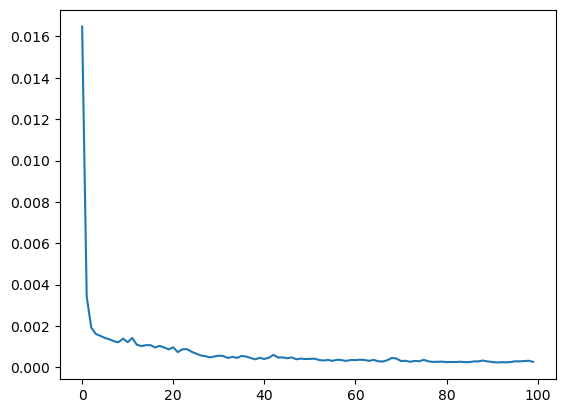

In [26]:
#plotting loss,it showsthat loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [27]:
#Predicting on train and test data
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

14/14 [==============================] - 0s 28ms/step


In [28]:
#inverse transforn to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

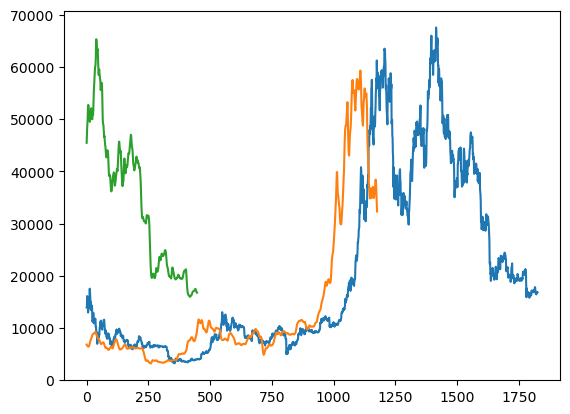

In [29]:
#comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [30]:
type(train_predict)

numpy.ndarray

In [31]:
test = np.vstack((train_predict,test_predict))

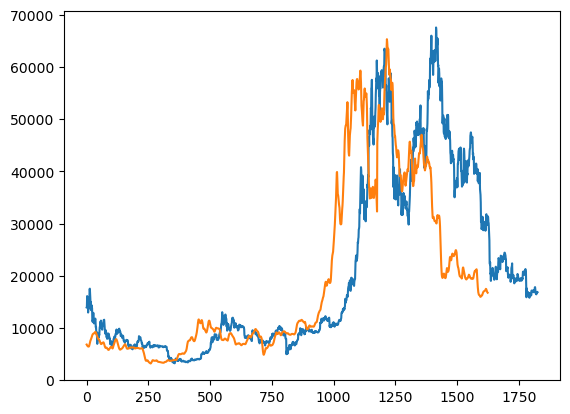

In [32]:
#combining the predicted data to creatye uniforn data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [33]:
len(ds_test)

549

In [34]:
#getting  the last 100 days records
fut_inp = ds_test[270:]

In [35]:
fut_inp = fut_inp.reshape(1,-1)

In [36]:
tmp_inp = list(fut_inp)

In [37]:
#creating list of the last 100 days
tmp_inp = tmp_inp[0].tolist()


In [38]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=(len(ds_test)-271)
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)
        

[[0.20944958925247192], [0.209249809384346], [0.20891134440898895], [0.20847199857234955], [0.20796917378902435], [0.20742589235305786], [0.206853449344635], [0.20625634491443634], [0.20563571155071259], [0.20499129593372345], [0.20432262122631073], [0.20362894237041473], [0.20290960371494293], [0.20216421782970428], [0.20139209926128387], [0.20059305429458618], [0.19976677000522614], [0.1989130973815918], [0.19803187251091003], [0.19712315499782562], [0.19618692994117737], [0.1952231377363205], [0.19423209130764008], [0.1932137906551361], [0.19216838479042053], [0.19109608232975006], [0.18999697268009186], [0.18887126445770264], [0.18771924078464508], [0.18654096126556396]]


In [39]:
len(ds_scaled)


1827

In [40]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

In [41]:

ds_new = ds_scaled.tolist()

In [42]:
len(ds_new)


1827

In [43]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

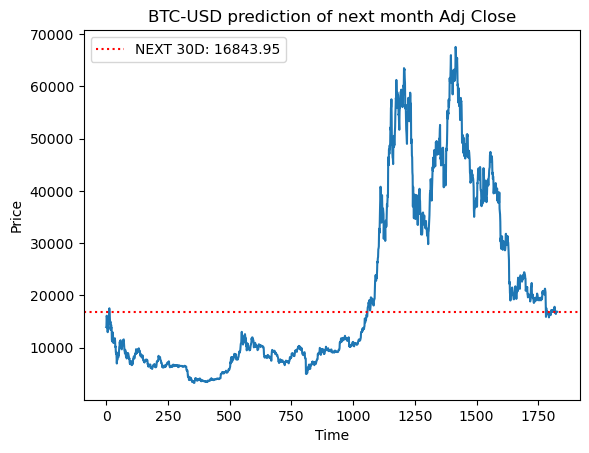

In [44]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month Adj Close".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], 
            color = 'red', linestyle = ':', 
            label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

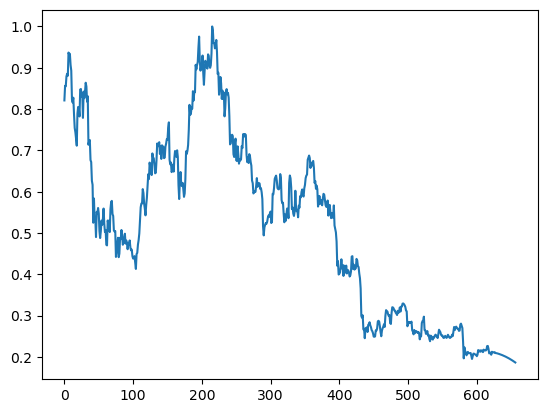

In [45]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

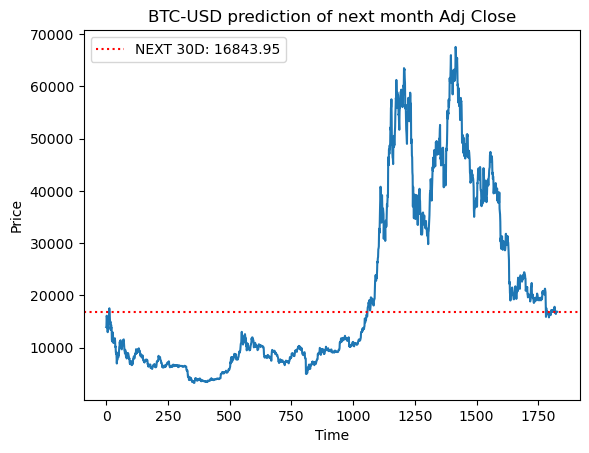

In [46]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month Adj Close".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()